In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
from sklearn.metrics import classification_report

C:\Users\zoeyl\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zoeyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('augmented_data_wcomment.csv')
#df = df[['Consumer complaint narrative','Product']]
#df = df[pd.notnull(df['Consumer complaint narrative'])]
#df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

,Unnamed: 0,Topic Title,Category,Tags,Author,Leading Comment,Likes,Views,Replies
0,0,About the Financial Management category,Financial Management,[],Kane,Have questions about Financial Management? Thi...,0,0,0
1,1,Unit cost allowance for prep services,Financial Management,[],KeithH,"Hi! For those that are using prep centers, ho...",1,23,2
2,2,Unit cost allowance for prep services,Financial Management,[],KeithH,We are currently paying for prep and packaging...,1,23,2
3,3,Unit cost allowance for prep services,Financial Management,[],KeithH,$0.90/unit for a single seems very high if you...,1,23,2
4,4,Cashback cards for non US citizens?,Financial Management,[],Lazar,"When speaking about cashback cards,I hear peop...",0,149,2
5,5,Cashback cards for non US citizens?,Financial Management,[],Lazar,That’s a good question - anyone here have any ...,0,149,2
6,6,Cashback cards for non US citizens?,Financial Management,[],Lazar,\n\n\n LizD:\n\nI would definitely do a Google...,0,149,2
7,7,Purchase Orders for Bundles,Financial Management,['Accounting & Bookkeeping'],Mitch,"Good Morning,\nWhat does everyone use to creat...",4,146,3
8,8,Purchase Orders for Bundles,Financial Management,['Accounting & Bookkeeping'],Mitch,@APlusSeller I’m not sure if I am understandin...,4,146,3
9,9,Purchase Orders for Bundles,Financial Management,['Accounting & Bookkeeping'],Mitch,@Mitch That’s what I’m asking. Is there a soft...,4,146,3


In [3]:
df.shape

(950, 9)

## Tokenization

In [4]:
df['Tokens'] = df['Category'] + ' ' + df['Topic Title'] + ' ' + df['Tags'] + ' ' + df['Leading Comment']

In [5]:
df['Tokens'] = df['Tokens'].str.replace('  ', ' ')
df['Tokens'].head()

0    Financial Management About the Financial Manag...
1    Financial Management Unit cost allowance for p...
2    Financial Management Unit cost allowance for p...
3    Financial Management Unit cost allowance for p...
4    Financial Management Cashback cards for non US...
Name: Tokens, dtype: object

In [6]:
df['Tokens'][1]

'Financial Management Unit cost allowance for prep services [] Hi! For those that are using prep centers, how much cost do you add on per unit to account for all expenses for prepping? Prep center we are trying to use charges for receiving, per unit prepping and boxes. TIA'

In [7]:
df.index = range(950)

In [8]:
df['Tokens'].apply(lambda x: len(str(x).split(' '))).sum()

57570

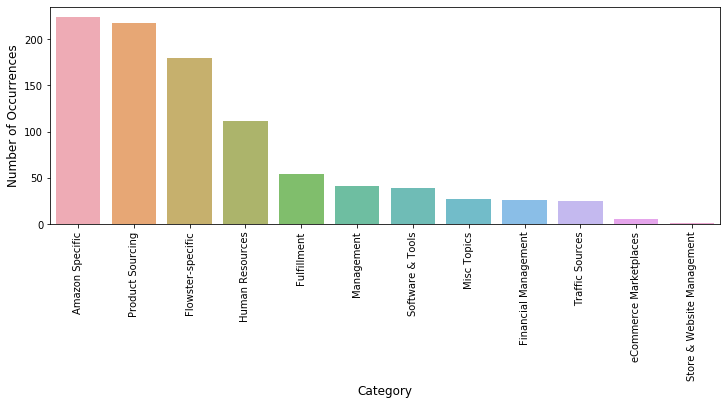

In [9]:
cnt_pro = df['Category'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Let's have a look a few examples of Tokens and its associated category.

In [10]:
def print_token(index):
    example = df[df.index == index][['Tokens', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

In [11]:
print_token(12)

Financial Management Sales tax ['Accounting & Bookkeeping'] We firmly believe that the marketplaces should be doing filing for sellers of that size and that you should only have to file in your home state. That said, what we believe doesn’t really matter and you shoul dof course consult with your accountant.
There are software tools to help (TaxJar, Avalara, etc), and accountants to file for you in the various states. However, there isn’t a super inexpensive way to do this.
Category: Financial Management


## Text Preprocessing

In [12]:
from bs4 import BeautifulSoup
def cleanText(text):
    text=str(text)
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

def data_cleaning(data, column):
    # Change to lowercase:
    data[column] = data[column].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    # Removing Punctuation:
    data[column] = data[column].str.replace('[^\w\s]','')
    # Removal of Stop Words:
    data[column] = data[column].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
    # Removing extra space:
    data[column] = data[column].str.strip()
    
df['Tokens'] = df['Tokens'].apply(cleanText)
data_cleaning(df, 'Tokens')

In [13]:
df['Tokens'][30]

'product sourcing top 10 tips grow business rapidly purchasing working amazon seller last 6 years want tips selling growing business fastly like grow business tips please read carefully top 10 amazon selling tips optimize product details search use competitive pricing take professional product images try buy bo work continually improve performance consider using fulfillment amazon follow amazons rules leverage product reviews advantage make customer service top priority manage amazon inventory proactively'

### Train/test split of 70/30.

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [15]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [16]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Tokens']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Tokens']), tags=[r.Category]), axis=1)

In [17]:
train_tagged.values[30]

TaggedDocument(words=['fulfillment', 'ship', 'products', 'ltl', 'spd', 'shipping', 'shipments', 'send', 'amazon', 'usually', 'try', 'build', 'sample', 'order', 'see', 'makes', 'sense', 'rule', 'thumb', 'weve', 'found', 'doesnt', 'always', 'make', 'sense', 'palletize', 'shipments', 'hit', '1100', 'lb', 'mark', 'amazon', 'make', 'us', 'break', 'locations', 'thing', 'consider', 'pallets', 'longer', 'shipping', 'time', 'pallets', 'also', 'take', 'longer', 'inventory', 'get', 'unloaded', 'active', 'especially', 'q4', 'new', 'fulfillment', 'locations'], tags=['Fulfillment'])

## Trainning the Model

We set the minimum word count to 2 in order to discard words with very few occurrences.

In [18]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [19]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<?, ?it/s]


Let’s train a Word2Vec model on our own corpus first.

In [20]:
%%time

tokens = df['Tokens'].apply(lambda x: x.split())

model_w2v = gensim.models.Word2Vec(
            tokens,
            size=1977, # desired no. of features/independent variables
            window=2, # context window size
            min_count=1, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokens, total_examples= len(df['Tokens']), epochs=20)

Wall time: 15.2 s


(595137, 648320)

In [21]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [22]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [23]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Testing accuracy 0.18947368421052632
Testing F1 score: 0.17324705548460337
                        precision    recall  f1-score   support

       Amazon Specific       0.20      0.21      0.21        66
  Financial Management       0.00      0.00      0.00         6
     Flowster-specific       0.24      0.25      0.24        57
           Fulfillment       0.29      0.11      0.16        18
       Human Resources       0.12      0.10      0.11        42
            Management       0.00      0.00      0.00        13
           Misc Topics       0.00      0.00      0.00         6
      Product Sourcing       0.19      0.34      0.25        59
      Software & Tools       0.00      0.00      0.00         8
       Traffic Sources       0.00      0.00      0.00         7
eCommerce Marketplaces       0.00      0.00      0.00         3

              accuracy                           0.19       285
             macro avg       0.09      0.09      0.09       285
          weighted avg     

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### DBOW

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

In [25]:
%%time
for epoch in range(50):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<?, ?it/s]

Wall time: 2.25 s


### Buliding the final vector feature for the classifier and training Logistic Regression

In [26]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [27]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [28]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Testing accuracy 0.23859649122807017
Testing F1 score: 0.2328825888797595
                        precision    recall  f1-score   support

       Amazon Specific       0.25      0.24      0.24        66
  Financial Management       0.40      0.33      0.36         6
     Flowster-specific       0.32      0.33      0.32        57
           Fulfillment       0.40      0.11      0.17        18
       Human Resources       0.23      0.17      0.19        42
            Management       0.00      0.00      0.00        13
           Misc Topics       0.33      0.17      0.22         6
      Product Sourcing       0.19      0.31      0.24        59
      Software & Tools       0.12      0.12      0.12         8
       Traffic Sources       0.33      0.29      0.31         7
eCommerce Marketplaces       0.00      0.00      0.00         3

              accuracy                           0.24       285
             macro avg       0.23      0.19      0.20       285
          weighted avg      

#### Distributed Memory with Averaging

In [29]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 666000.99it/s]


In [30]:
%%time
for epoch in range(50):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<?, ?it/s]


Wall time: 3.07 s


### Train Logistic Regression

In [31]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.6421052631578947
Testing F1 score: 0.6398718437061967
                        precision    recall  f1-score   support

       Amazon Specific       0.71      0.73      0.72        66
  Financial Management       0.40      0.33      0.36         6
     Flowster-specific       0.80      0.82      0.81        57
           Fulfillment       0.78      0.78      0.78        18
       Human Resources       0.89      0.57      0.70        42
            Management       0.67      0.15      0.25        13
           Misc Topics       0.40      0.33      0.36         6
      Product Sourcing       0.50      0.63      0.56        59
      Software & Tools       0.00      0.00      0.00         8
       Traffic Sources       0.56      0.71      0.63         7
eCommerce Marketplaces       0.18      0.67      0.29         3

              accuracy                           0.64       285
             macro avg       0.53      0.52      0.49       285
          weighted avg       

## Model Pairing

Combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance. 
Pairing the models together for evaluation.

In [32]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [33]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [34]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [35]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [36]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.6877192982456141
Testing F1 score: 0.6928600596217331
                            precision    recall  f1-score   support

           Amazon Specific       0.76      0.83      0.80        66
      Financial Management       0.67      0.33      0.44         6
         Flowster-specific       0.77      0.75      0.76        57
               Fulfillment       0.59      0.72      0.65        18
           Human Resources       0.77      0.79      0.78        42
                Management       0.62      0.38      0.48        13
               Misc Topics       0.33      0.50      0.40         6
          Product Sourcing       0.81      0.58      0.67        59
          Software & Tools       0.25      0.25      0.25         8
Store & Website Management       0.00      0.00      0.00         0
           Traffic Sources       0.42      0.71      0.53         7
    eCommerce Marketplaces       0.11      0.33      0.17         3

                  accuracy               

C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\zoeyl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
